**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/10_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/10_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

And PyTorch ≥ 2.4.0:

In [2]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.4.0")

If using Colab, a few libraries are not pre-installed so we must install them manually:

In [3]:
if "google.colab" in sys.modules:
    %pip install -q torchmetrics

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

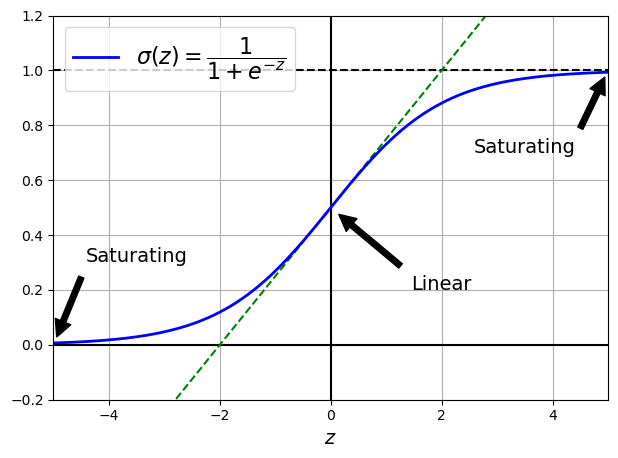

In [6]:
# extra code – this cell generates and saves Figure 10–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Glorot and He Initialization

In [7]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [9]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [10]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Better Activation Functions

### Leaky ReLU

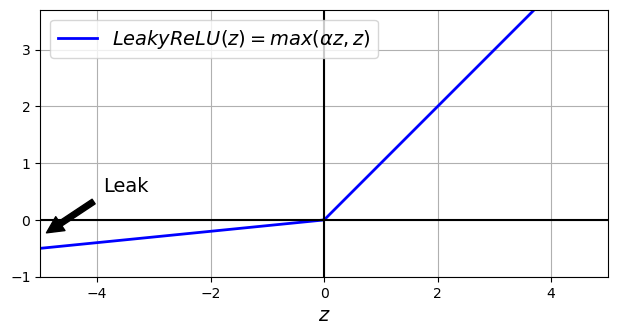

In [11]:
# extra code – this cell generates and saves Figure 10–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [12]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")

Parameter containing:
tensor([[ 0.0269, -0.2432, -0.2572,  ..., -0.2289,  0.2108, -0.1595],
        [ 0.1094, -0.0500,  0.0935,  ..., -0.3174,  0.0225, -0.1207],
        [ 0.2411, -0.2163,  0.2062,  ...,  0.2084, -0.3047, -0.3274],
        ...,
        [-0.0538, -0.2066,  0.1297,  ..., -0.1255,  0.1402, -0.1600],
        [-0.2085,  0.3175,  0.2816,  ..., -0.2704, -0.1005, -0.2096],
        [-0.2170,  0.2361,  0.2672,  ...,  0.0047,  0.2922, -0.0883]],
       requires_grad=True)

### ELU

Implementing ELU in PyTorch is trivial, just add an `ELU` layer after each `Linear` layer in your model, and make sure to use Kaiming initialization for these `Linear` layers:

In [13]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)

Parameter containing:
tensor([[ 0.0274, -0.2480, -0.2623,  ..., -0.2335,  0.2150, -0.1627],
        [ 0.1115, -0.0510,  0.0954,  ..., -0.3237,  0.0230, -0.1231],
        [ 0.2459, -0.2206,  0.2103,  ...,  0.2125, -0.3107, -0.3339],
        ...,
        [-0.0548, -0.2107,  0.1323,  ..., -0.1280,  0.1430, -0.1632],
        [-0.2126,  0.3238,  0.2871,  ..., -0.2757, -0.1025, -0.2137],
        [-0.2213,  0.2407,  0.2725,  ...,  0.0048,  0.2980, -0.0900]],
       requires_grad=True)

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

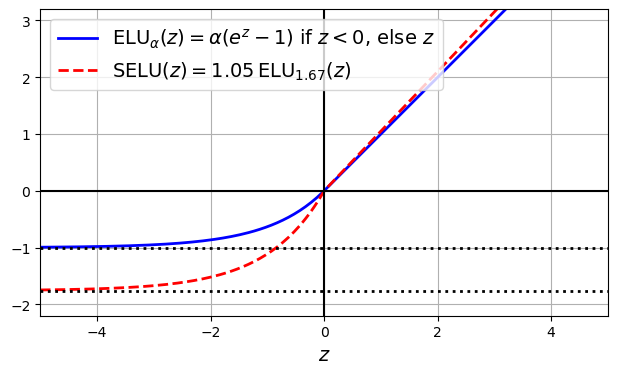

In [14]:
# extra code – this cell generates and saves Figure 10–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [15]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)

Parameter containing:
tensor([[ 0.0274, -0.2480, -0.2623,  ..., -0.2335,  0.2150, -0.1627],
        [ 0.1115, -0.0510,  0.0954,  ..., -0.3237,  0.0230, -0.1231],
        [ 0.2459, -0.2206,  0.2103,  ...,  0.2125, -0.3107, -0.3339],
        ...,
        [-0.0548, -0.2107,  0.1323,  ..., -0.1280,  0.1430, -0.1632],
        [-0.2126,  0.3238,  0.2871,  ..., -0.2757, -0.1025, -0.2137],
        [-0.2213,  0.2407,  0.2725,  ...,  0.0048,  0.2980, -0.0900]],
       requires_grad=True)

### GELU, Swish and Mish

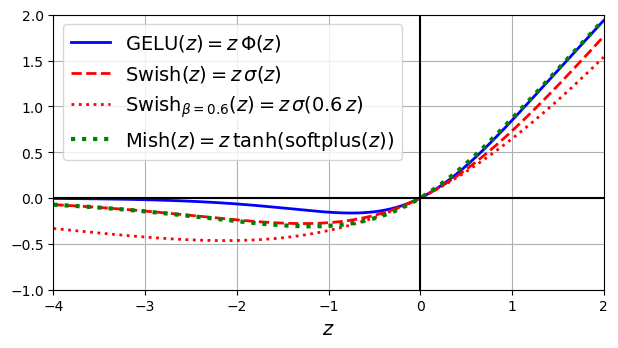

In [16]:
# extra code – this cell generates and saves Figure 10–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

## Batch Normalization

With the BN layers after the activation functions:

In [17]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [18]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [19]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

Quite often, applying BN before the activation function works better. Moreover, the `Linear` layer before a `BatchNorm1d` layer does not need to have bias terms, since the `BatchNorm1d` layer has some as well. So you can set `bias=False` when creating those layers:

In [20]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

## Layer Normalization

In [21]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions

In [22]:
means = inputs.mean(dim=[2, 3], keepdim=True)
vars_ = inputs.var(dim=[2, 3], keepdim=True, unbiased=False)
stds = torch.sqrt(vars_ + layer_norm.eps)
result2 = layer_norm.weight * (inputs - means) / stds + layer_norm.bias
assert torch.allclose(result, result2)

In [23]:
layer_norm = nn.LayerNorm([3, 100, 200])
result = layer_norm(inputs)  # normalizes over the last three dimensions

## Gradient Clipping

See the line `nn.utils.clip_grad_norm_(...)` in the training function in the next section.

# Reusing Pretrained Layers

## Transfer Learning with PyTorch

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 20 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Linear` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 12).

Let's fetch the Fashion MNIST data and split it into datasets A and B:

In [24]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

Let's define the `evaluate_tm()` and `train()` functions, much like in Chapter 10:

In [25]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

Let's find out which hardware accelerator device we can use:

In [26]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

Let's define our first model for task A:

In [27]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

In [28]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [29]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.5927, train metric: 0.8094, valid metric: 0.8430
Epoch 2/20, train loss: 0.3401, train metric: 0.8826, valid metric: 0.8925
Epoch 3/20, train loss: 0.2990, train metric: 0.8959, valid metric: 0.8880
Epoch 4/20, train loss: 0.2759, train metric: 0.9042, valid metric: 0.8230
Epoch 5/20, train loss: 0.2606, train metric: 0.9085, valid metric: 0.8780
Epoch 6/20, train loss: 0.2467, train metric: 0.9126, valid metric: 0.9020
Epoch 7/20, train loss: 0.2347, train metric: 0.9178, valid metric: 0.8730
Epoch 8/20, train loss: 0.2264, train metric: 0.9207, valid metric: 0.9095
Epoch 9/20, train loss: 0.2181, train metric: 0.9238, valid metric: 0.9135
Epoch 10/20, train loss: 0.2105, train metric: 0.9258, valid metric: 0.9020
Epoch 11/20, train loss: 0.2051, train metric: 0.9282, valid metric: 0.9115
Epoch 12/20, train loss: 0.1992, train metric: 0.9289, valid metric: 0.8945
Epoch 13/20, train loss: 0.1947, train metric: 0.9302, valid metric: 0.9185
Epoch 14/20, train lo

In [30]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

In [31]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [32]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.7803, train metric: 0.6000, valid metric: 0.4968
Epoch 2/20, train loss: 0.7394, train metric: 0.6000, valid metric: 0.4964
Epoch 3/20, train loss: 0.7059, train metric: 0.6000, valid metric: 0.4964
Epoch 4/20, train loss: 0.6779, train metric: 0.6000, valid metric: 0.4972
Epoch 5/20, train loss: 0.6541, train metric: 0.6000, valid metric: 0.4980
Epoch 6/20, train loss: 0.6326, train metric: 0.6000, valid metric: 0.4988
Epoch 7/20, train loss: 0.6145, train metric: 0.6000, valid metric: 0.4992
Epoch 8/20, train loss: 0.5985, train metric: 0.6000, valid metric: 0.5040
Epoch 9/20, train loss: 0.5828, train metric: 0.7000, valid metric: 0.5165
Epoch 10/20, train loss: 0.5682, train metric: 0.8000, valid metric: 0.5339
Epoch 11/20, train loss: 0.5544, train metric: 0.8000, valid metric: 0.5622
Epoch 12/20, train loss: 0.5418, train metric: 0.8000, valid metric: 0.5878
Epoch 13/20, train loss: 0.5300, train metric: 0.8000, valid metric: 0.6088
Epoch 14/20, train lo

In [33]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.7162, device='mps:0')

In [34]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

In [35]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [36]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/10, train loss: 1.0524, train metric: 0.2500, valid metric: 0.1588
Epoch 2/10, train loss: 0.9711, train metric: 0.0500, valid metric: 0.0888
Epoch 3/10, train loss: 0.9195, train metric: 0.0000, valid metric: 0.0880
Epoch 4/10, train loss: 0.8821, train metric: 0.0500, valid metric: 0.1394
Epoch 5/10, train loss: 0.8516, train metric: 0.0500, valid metric: 0.2438
Epoch 6/10, train loss: 0.8246, train metric: 0.1000, valid metric: 0.3504
Epoch 7/10, train loss: 0.7995, train metric: 0.3500, valid metric: 0.4044
Epoch 8/10, train loss: 0.7759, train metric: 0.3500, valid metric: 0.4378
Epoch 9/10, train loss: 0.7535, train metric: 0.5500, valid metric: 0.4588
Epoch 10/10, train loss: 0.7320, train metric: 0.6000, valid metric: 0.4809


In [37]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [38]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.7115, train metric: 0.6000, valid metric: 0.5058
Epoch 2/20, train loss: 0.6851, train metric: 0.6000, valid metric: 0.5444
Epoch 3/20, train loss: 0.6603, train metric: 0.6000, valid metric: 0.5974
Epoch 4/20, train loss: 0.6370, train metric: 0.6000, valid metric: 0.6705
Epoch 5/20, train loss: 0.6149, train metric: 0.7000, valid metric: 0.7343
Epoch 6/20, train loss: 0.5942, train metric: 0.7500, valid metric: 0.7880
Epoch 7/20, train loss: 0.5746, train metric: 0.8000, valid metric: 0.8239
Epoch 8/20, train loss: 0.5561, train metric: 0.9500, valid metric: 0.8488
Epoch 9/20, train loss: 0.5387, train metric: 0.9500, valid metric: 0.8711
Epoch 10/20, train loss: 0.5221, train metric: 0.9500, valid metric: 0.8869
Epoch 11/20, train loss: 0.5065, train metric: 0.9500, valid metric: 0.8968
Epoch 12/20, train loss: 0.4916, train metric: 0.9500, valid metric: 0.9062
Epoch 13/20, train loss: 0.4774, train metric: 0.9500, valid metric: 0.9155
Epoch 14/20, train lo

So, what's the final verdict?

In [39]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9301, device='mps:0')

# Faster Optimizers

In [40]:
# extra code – a little function to test an optimizer on Fashion MNIST

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    history = train(model, optimizer, xentropy, accuracy.to(device),
                    train_loader, valid_loader, n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [41]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5649, train metric: 0.7956, valid metric: 0.8514
Epoch 2/10, train loss: 0.4016, train metric: 0.8521, valid metric: 0.8456
Epoch 3/10, train loss: 0.3612, train metric: 0.8669, valid metric: 0.8596
Epoch 4/10, train loss: 0.3375, train metric: 0.8755, valid metric: 0.8730
Epoch 5/10, train loss: 0.3181, train metric: 0.8827, valid metric: 0.8746
Epoch 6/10, train loss: 0.3048, train metric: 0.8868, valid metric: 0.8758
Epoch 7/10, train loss: 0.2922, train metric: 0.8917, valid metric: 0.8794
Epoch 8/10, train loss: 0.2805, train metric: 0.8961, valid metric: 0.8770
Epoch 9/10, train loss: 0.2718, train metric: 0.8986, valid metric: 0.8776
Epoch 10/10, train loss: 0.2631, train metric: 0.9012, valid metric: 0.8724


## Momentum optimization

In [42]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
history_momentum, acc_momentum = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6130, train metric: 0.7774, valid metric: 0.7972
Epoch 2/10, train loss: 0.4828, train metric: 0.8269, valid metric: 0.8380
Epoch 3/10, train loss: 0.4390, train metric: 0.8435, valid metric: 0.8398
Epoch 4/10, train loss: 0.4175, train metric: 0.8509, valid metric: 0.8474
Epoch 5/10, train loss: 0.3960, train metric: 0.8585, valid metric: 0.8594
Epoch 6/10, train loss: 0.3905, train metric: 0.8614, valid metric: 0.8614
Epoch 7/10, train loss: 0.3812, train metric: 0.8635, valid metric: 0.8576
Epoch 8/10, train loss: 0.3671, train metric: 0.8698, valid metric: 0.8450
Epoch 9/10, train loss: 0.3684, train metric: 0.8686, valid metric: 0.8648
Epoch 10/10, train loss: 0.3556, train metric: 0.8730, valid metric: 0.8614


## Nesterov Accelerated Gradient

In [43]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9, nesterov=True, lr=0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5469, train metric: 0.8037, valid metric: 0.8286
Epoch 2/10, train loss: 0.4460, train metric: 0.8400, valid metric: 0.8462
Epoch 3/10, train loss: 0.4153, train metric: 0.8526, valid metric: 0.8454
Epoch 4/10, train loss: 0.3963, train metric: 0.8587, valid metric: 0.8636
Epoch 5/10, train loss: 0.3785, train metric: 0.8655, valid metric: 0.8598
Epoch 6/10, train loss: 0.3770, train metric: 0.8669, valid metric: 0.8586
Epoch 7/10, train loss: 0.3628, train metric: 0.8704, valid metric: 0.8636
Epoch 8/10, train loss: 0.3546, train metric: 0.8727, valid metric: 0.8654
Epoch 9/10, train loss: 0.3596, train metric: 0.8721, valid metric: 0.8604
Epoch 10/10, train loss: 0.3486, train metric: 0.8770, valid metric: 0.8620


## AdaGrad

In [44]:
model = build_model()  # extra code
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5721, train metric: 0.8066, valid metric: 0.8470
Epoch 2/10, train loss: 0.3803, train metric: 0.8594, valid metric: 0.8534
Epoch 3/10, train loss: 0.3454, train metric: 0.8726, valid metric: 0.8608
Epoch 4/10, train loss: 0.3241, train metric: 0.8785, valid metric: 0.8744
Epoch 5/10, train loss: 0.3076, train metric: 0.8851, valid metric: 0.8710
Epoch 6/10, train loss: 0.2947, train metric: 0.8905, valid metric: 0.8730
Epoch 7/10, train loss: 0.2824, train metric: 0.8947, valid metric: 0.8800
Epoch 8/10, train loss: 0.2737, train metric: 0.8975, valid metric: 0.8774
Epoch 9/10, train loss: 0.2652, train metric: 0.9003, valid metric: 0.8808
Epoch 10/10, train loss: 0.2573, train metric: 0.9045, valid metric: 0.8798


## RMSProp

In [45]:
model = build_model()  # extra code
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9, lr=0.05)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 2.7391, train metric: 0.4938, valid metric: 0.5482
Epoch 2/10, train loss: 1.3918, train metric: 0.4914, valid metric: 0.4170
Epoch 3/10, train loss: 1.4540, train metric: 0.4637, valid metric: 0.4140
Epoch 4/10, train loss: 1.5281, train metric: 0.4213, valid metric: 0.4770
Epoch 5/10, train loss: 1.6448, train metric: 0.4277, valid metric: 0.4304
Epoch 6/10, train loss: 1.3678, train metric: 0.4542, valid metric: 0.3724
Epoch 7/10, train loss: 1.5715, train metric: 0.4029, valid metric: 0.3520
Epoch 8/10, train loss: 1.5282, train metric: 0.4192, valid metric: 0.4774
Epoch 9/10, train loss: 1.2601, train metric: 0.5094, valid metric: 0.5280
Epoch 10/10, train loss: 1.2206, train metric: 0.5070, valid metric: 0.4086


## Adam Optimization

In [46]:
model = build_model()  # extra code
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adam, acc_adam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.1022, train metric: 0.6127, valid metric: 0.4870
Epoch 2/10, train loss: 1.2175, train metric: 0.4918, valid metric: 0.4574
Epoch 3/10, train loss: 1.2480, train metric: 0.4727, valid metric: 0.5036
Epoch 4/10, train loss: 1.2571, train metric: 0.4682, valid metric: 0.4220
Epoch 5/10, train loss: 1.3707, train metric: 0.4168, valid metric: 0.4768
Epoch 6/10, train loss: 1.2178, train metric: 0.4890, valid metric: 0.4688
Epoch 7/10, train loss: 1.2055, train metric: 0.4879, valid metric: 0.5122
Epoch 8/10, train loss: 1.1565, train metric: 0.5031, valid metric: 0.5276
Epoch 9/10, train loss: 1.3219, train metric: 0.4437, valid metric: 0.3872
Epoch 10/10, train loss: 1.3518, train metric: 0.4122, valid metric: 0.4170


**Adamax Optimization**

In [47]:
model = build_model()  # extra code
optimizer = torch.optim.Adamax(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adamax, acc_adamax = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6377, train metric: 0.7878, valid metric: 0.7668
Epoch 2/10, train loss: 0.4865, train metric: 0.8270, valid metric: 0.8372
Epoch 3/10, train loss: 0.4493, train metric: 0.8401, valid metric: 0.8444
Epoch 4/10, train loss: 0.4305, train metric: 0.8473, valid metric: 0.8406
Epoch 5/10, train loss: 0.4180, train metric: 0.8525, valid metric: 0.8476
Epoch 6/10, train loss: 0.4051, train metric: 0.8561, valid metric: 0.8612
Epoch 7/10, train loss: 0.3957, train metric: 0.8587, valid metric: 0.8460
Epoch 8/10, train loss: 0.3954, train metric: 0.8603, valid metric: 0.8338
Epoch 9/10, train loss: 0.3845, train metric: 0.8643, valid metric: 0.8524
Epoch 10/10, train loss: 0.3874, train metric: 0.8633, valid metric: 0.8544


**Nadam Optimization**

In [48]:
model = build_model()  # extra code
optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_nadam, acc_nadam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.7685, train metric: 0.3009, valid metric: 0.1994
Epoch 2/10, train loss: 2.2746, train metric: 0.1258, valid metric: 0.0934
Epoch 3/10, train loss: 2.3078, train metric: 0.1014, valid metric: 0.1054
Epoch 4/10, train loss: 2.2210, train metric: 0.1327, valid metric: 0.1716
Epoch 5/10, train loss: 2.2143, train metric: 0.1250, valid metric: 0.0992
Epoch 6/10, train loss: 2.3072, train metric: 0.1019, valid metric: 0.1402
Epoch 7/10, train loss: 2.0420, train metric: 0.1745, valid metric: 0.1920
Epoch 8/10, train loss: 1.7421, train metric: 0.1949, valid metric: 0.1958
Epoch 9/10, train loss: 1.7741, train metric: 0.1993, valid metric: 0.1984
Epoch 10/10, train loss: 1.7834, train metric: 0.1949, valid metric: 0.1912


**AdamW Optimization**

In [49]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.999),
                              weight_decay=1e-5, lr=0.05)
history_adamw, acc_adamw = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.0392, train metric: 0.6301, valid metric: 0.6644
Epoch 2/10, train loss: 1.3280, train metric: 0.4825, valid metric: 0.3028
Epoch 3/10, train loss: 1.4901, train metric: 0.3362, valid metric: 0.2776
Epoch 4/10, train loss: 1.4856, train metric: 0.3245, valid metric: 0.1864
Epoch 5/10, train loss: 1.6801, train metric: 0.2313, valid metric: 0.2050
Epoch 6/10, train loss: 1.6395, train metric: 0.2532, valid metric: 0.3026
Epoch 7/10, train loss: 1.5381, train metric: 0.2836, valid metric: 0.2984
Epoch 8/10, train loss: 1.7255, train metric: 0.2216, valid metric: 0.1844
Epoch 9/10, train loss: 1.7857, train metric: 0.1956, valid metric: 0.1912
Epoch 10/10, train loss: 1.7525, train metric: 0.1953, valid metric: 0.2026


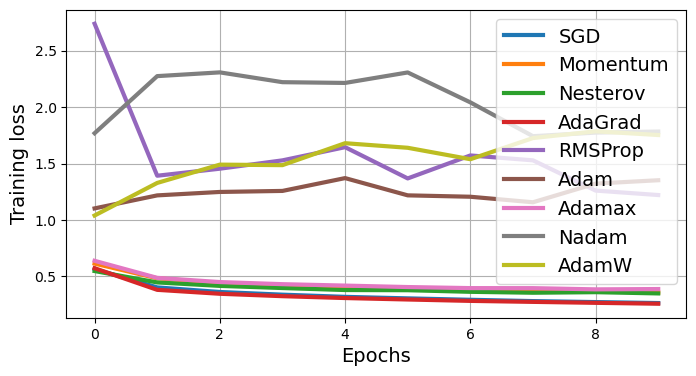

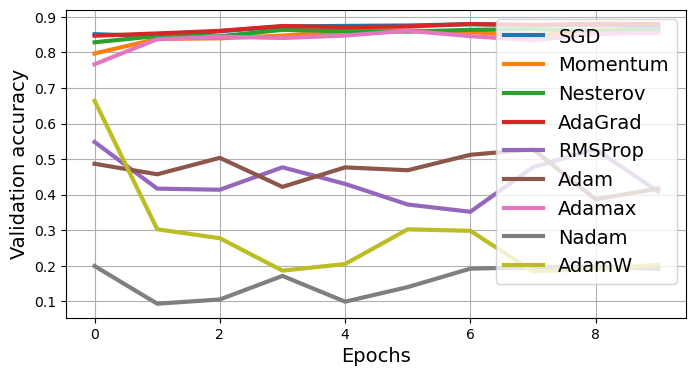

In [50]:
# extra code – visualize the learning curves of all the optimizers

for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw), opt_names.split()):
        plt.plot(history[plot], label=opt_name, linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training loss", "valid_metrics": "Validation accuracy"}[plot])
    plt.legend(loc="upper right")
    plt.show()

# Learning Rate Scheduling

In [51]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [52]:
def train_with_scheduler(model, optimizer, loss_fn, metric, train_loader,
                         valid_loader, n_epochs, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        losses = []
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_metric)
        else:
            scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [53]:
history_exp, acc_exp = test_scheduler(model, optimizer, exp_scheduler)  # extra code

Epoch 1/10, train loss: 0.5649, train metric: 0.7956, valid metric: 0.8514
Learning rate: 0.04500
Epoch 2/10, train loss: 0.3974, train metric: 0.8525, valid metric: 0.8438
Learning rate: 0.04050
Epoch 3/10, train loss: 0.3550, train metric: 0.8689, valid metric: 0.8568
Learning rate: 0.03645
Epoch 4/10, train loss: 0.3299, train metric: 0.8785, valid metric: 0.8712
Learning rate: 0.03281
Epoch 5/10, train loss: 0.3094, train metric: 0.8859, valid metric: 0.8776
Learning rate: 0.02952
Epoch 6/10, train loss: 0.2942, train metric: 0.8917, valid metric: 0.8770
Learning rate: 0.02657
Epoch 7/10, train loss: 0.2813, train metric: 0.8956, valid metric: 0.8800
Learning rate: 0.02391
Epoch 8/10, train loss: 0.2695, train metric: 0.9006, valid metric: 0.8780
Learning rate: 0.02152
Epoch 9/10, train loss: 0.2596, train metric: 0.9031, valid metric: 0.8828
Learning rate: 0.01937
Epoch 10/10, train loss: 0.2501, train metric: 0.9082, valid metric: 0.8828
Learning rate: 0.01743


In [54]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [55]:
history_perf, acc_perf = test_scheduler(model, optimizer, perf_scheduler)  # extra code

Epoch 1/10, train loss: 0.5649, train metric: 0.7956, valid metric: 0.8514
Learning rate: 0.05000
Epoch 2/10, train loss: 0.4016, train metric: 0.8521, valid metric: 0.8456
Learning rate: 0.05000
Epoch 3/10, train loss: 0.3612, train metric: 0.8669, valid metric: 0.8596
Learning rate: 0.05000
Epoch 4/10, train loss: 0.3375, train metric: 0.8755, valid metric: 0.8730
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3181, train metric: 0.8827, valid metric: 0.8746
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3048, train metric: 0.8868, valid metric: 0.8758
Learning rate: 0.05000
Epoch 7/10, train loss: 0.2922, train metric: 0.8917, valid metric: 0.8794
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2805, train metric: 0.8961, valid metric: 0.8770
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2718, train metric: 0.8986, valid metric: 0.8776
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2631, train metric: 0.9012, valid metric: 0.8724
Learning rate: 0.00500


In [56]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3)

The following scheduler is equivalent to the previous one:

In [57]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch, 3) / 3) * (1.0 - 0.1) + 0.1)

In [58]:
# extra code
def train_with_warmup(model, optimizer, loss_fn, metric, train_loader,
                      valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        
        warmup_scheduler.step()

        # extra code
        losses = []
        metric.reset()
        
        for X_batch, y_batch in train_loader:

            # extra code
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
        
        if epoch >= 3:  # deactivate other scheduler(s) during warmup
            scheduler.step(val_metric)

        # extra code
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                          n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [59]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler,
                      n_epochs=10, batch_size=32)

Epoch 1/10, train loss: 0.6208, train metric: 0.7816, valid metric: 0.8350
Learning rate: 0.00500
Epoch 2/10, train loss: 0.4480, train metric: 0.8375, valid metric: 0.8368
Learning rate: 0.00500
Epoch 3/10, train loss: 0.4015, train metric: 0.8525, valid metric: 0.8538
Learning rate: 0.00500
Epoch 4/10, train loss: 0.3603, train metric: 0.8682, valid metric: 0.8680
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3345, train metric: 0.8777, valid metric: 0.8718
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3170, train metric: 0.8841, valid metric: 0.8670
Learning rate: 0.05000
Epoch 7/10, train loss: 0.3015, train metric: 0.8880, valid metric: 0.8714
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2883, train metric: 0.8939, valid metric: 0.8654
Learning rate: 0.00500
Epoch 9/10, train loss: 0.2788, train metric: 0.8959, valid metric: 0.8758
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2678, train metric: 0.9008, valid metric: 0.8688
Learning rate: 0.05000


({'train_losses': [np.float64(0.620848966813351),
   np.float64(0.4480280023698823),
   np.float64(0.40154592372550735),
   np.float64(0.36027570329324804),
   np.float64(0.334542346861454),
   np.float64(0.31703176493732094),
   np.float64(0.30152472670971825),
   np.float64(0.28825892347662585),
   np.float64(0.2788155869412311),
   np.float64(0.26783461966066946)],
  'train_metrics': [0.7815636396408081,
   0.8375272750854492,
   0.8524909019470215,
   0.8682000041007996,
   0.8776545524597168,
   0.8840545415878296,
   0.8880363702774048,
   0.893927276134491,
   0.8958727121353149,
   0.9007999897003174],
  'valid_metrics': [0.8349999785423279,
   0.8367999792098999,
   0.8537999987602234,
   0.8679999709129333,
   0.8718000054359436,
   0.8669999837875366,
   0.871399998664856,
   0.8654000163078308,
   0.8758000135421753,
   0.8687999844551086]},
 tensor(0.8631, device='mps:0'))

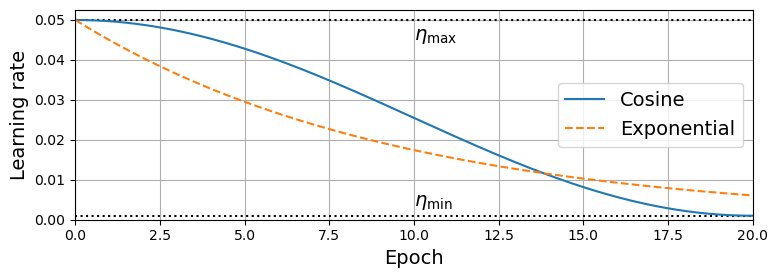

In [60]:
t = np.linspace(0, 20, 400)
eta_min = 0.001
eta_max = 0.05
t2 = 20
eta_cos_t = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(t / t2 * np.pi))
eta_exp_t = 0.9 ** t * eta_max

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 20, color="k", linestyle="dotted")
plt.plot(t, eta_cos_t, label="Cosine")
plt.plot(t, eta_exp_t, "--", label="Exponential")
plt.legend(loc="center right")
plt.text(10, eta_min + 0.0025, r"$\eta_\text{min}$")
plt.text(10, eta_max - 0.005, r"$\eta_\text{max}$")
plt.axis([0, 20, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")

save_fig("cosine_annealing_diagram")

In [61]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20, eta_min=0.001)

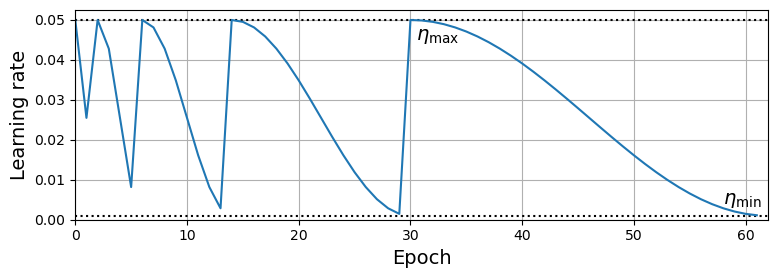

In [62]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_repeat_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=0.001)

lrs = []
for epoch in range(62):
    lrs.append(cosine_repeat_scheduler.get_last_lr()[0])
    cosine_repeat_scheduler.step()

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 64, color="k", linestyle="dotted")
plt.plot(lrs, label="Cosine")
plt.text(30.5, eta_max - 0.005, r"$\eta_\text{max}$")
plt.text(58, eta_min + 0.003, r"$\eta_\text{min}$")
plt.axis([0, 62, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")

save_fig("cosine_annealing_warm_restarts_diagram")

Let's list all the schedulers and link to their documentation page:

In [63]:
import re

DOCS_URL = "https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler"
for name in sorted(dir(torch.optim.lr_scheduler)):
    scheduler = getattr(torch.optim.lr_scheduler, name)
    if (not name.startswith("_") and isinstance(scheduler, type) and
        issubclass(scheduler, torch.optim.lr_scheduler.LRScheduler)):
            print(f"• {DOCS_URL}.{name}.html")

• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ChainedScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ConstantLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiplicativeLR.html
• https://pytorch.org/docs/sta

# Avoiding Overfitting Through Regularization

## ℓ₁ and ℓ₂ regularization

In [64]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
history = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.5638, train metric: 0.7966, valid metric: 0.8396
Epoch 2/10, train loss: 0.4011, train metric: 0.8514, valid metric: 0.8526
Epoch 3/10, train loss: 0.3614, train metric: 0.8671, valid metric: 0.8612
Epoch 4/10, train loss: 0.3384, train metric: 0.8749, valid metric: 0.8752
Epoch 5/10, train loss: 0.3182, train metric: 0.8822, valid metric: 0.8744
Epoch 6/10, train loss: 0.3055, train metric: 0.8879, valid metric: 0.8736
Epoch 7/10, train loss: 0.2936, train metric: 0.8903, valid metric: 0.8774
Epoch 8/10, train loss: 0.2818, train metric: 0.8963, valid metric: 0.8782
Epoch 9/10, train loss: 0.2737, train metric: 0.8975, valid metric: 0.8770
Epoch 10/10, train loss: 0.2641, train metric: 0.9015, valid metric: 0.8582


In [65]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l2_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l2_loss = sum(param.pow(2.0).sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l2_loss
        total_loss += loss.item()
        total_l2_loss += l2_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l2 loss: {total_l2_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l2 loss: 642.979 – loss: 0.627
Epoch 2/3 – l2 loss: 652.308 – loss: 0.467
Epoch 3/3 – l2 loss: 653.393 – loss: 0.427


In [66]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
params_bias_and_bn = [
    param for name, param in model.named_parameters()
    if "bias" in name or "bn" in name]
optimizer = torch.optim.SGD([
    {"params": params_to_regularize, "weight_decay": 1e-4},
    {"params": params_bias_and_bn, "weight_decay": 0},
    ], lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.564
Epoch 2/3 – loss: 0.402
Epoch 3/3 – loss: 0.362


In [67]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l1_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l1_loss = sum(param.abs().sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l1_loss
        total_loss += loss.item()
        total_l1_loss += l1_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l1 loss: {total_l1_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l1 loss: 5733.411 – loss: 1.139
Epoch 2/3 – l1 loss: 5122.790 – loss: 0.920
Epoch 3/3 – l1 loss: 4567.807 – loss: 0.829


## Dropout

In [68]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), nn.Linear(28 * 28, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 10)
).to(device)
model.apply(use_he_init)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
history_dropout, acc_dropout = test_optimizer(model, optimizer, batch_size=32)

Epoch 1/10, train loss: 0.6760, train metric: 0.7537, valid metric: 0.8434
Epoch 2/10, train loss: 0.5124, train metric: 0.8136, valid metric: 0.8416
Epoch 3/10, train loss: 0.4734, train metric: 0.8255, valid metric: 0.8560
Epoch 4/10, train loss: 0.4516, train metric: 0.8341, valid metric: 0.8616
Epoch 5/10, train loss: 0.4339, train metric: 0.8393, valid metric: 0.8592
Epoch 6/10, train loss: 0.4279, train metric: 0.8423, valid metric: 0.8662
Epoch 7/10, train loss: 0.4137, train metric: 0.8464, valid metric: 0.8652
Epoch 8/10, train loss: 0.4055, train metric: 0.8497, valid metric: 0.8680
Epoch 9/10, train loss: 0.4001, train metric: 0.8531, valid metric: 0.8710
Epoch 10/10, train loss: 0.3917, train metric: 0.8544, valid metric: 0.8680


**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## Monte-Carlo (MC) Dropout

In [69]:
model.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()

X_new = torch.FloatTensor(fashion_mnist.data[:3].reshape(3, 1, 28, 28) / 255)
X_new = X_new.to(device)

torch.manual_seed(42)
with torch.no_grad():
    X_new_repeated = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model(X_new_repeated).reshape(3, 100, 10)
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)

In [70]:
y_probas.cpu().numpy().round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.5 , 0.03, 0.03, 0.22, 0.02, 0.  , 0.2 , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [71]:
y_std = y_probas_all.std(dim=1)
y_std.cpu().numpy().round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.06],
       [0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.16, 0.03, 0.04, 0.15, 0.03, 0.  , 0.09, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [72]:
class McDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)

In [73]:
def mean_prediction(model, X, n_repeats):
    X_new_repeated = X_new.repeat_interleave(n_repeats, dim=0)
    y_logits = model(X_new_repeated)
    y_logits_all = y_logits.reshape(X.shape[0], n_repeats, *y_logits.shape[1:])
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    return y_probas_all.mean(dim=1)

In [74]:
mean_prediction(model, X_new, 100)

tensor([[1.4950e-05, 2.5526e-05, 1.3740e-05, 9.2416e-05, 4.9318e-06, 1.6209e-03,
         1.5389e-05, 2.7606e-02, 3.8970e-04, 9.7022e-01],
        [9.8833e-01, 2.2369e-06, 7.8922e-04, 5.4695e-04, 4.5148e-06, 3.6351e-08,
         1.0320e-02, 2.1250e-09, 6.7798e-06, 2.7890e-09],
        [4.8266e-01, 3.1024e-02, 2.8477e-02, 2.4390e-01, 3.0376e-02, 6.5671e-04,
         1.7832e-01, 6.3975e-04, 3.5033e-03, 4.5147e-04]], device='mps:0',
       grad_fn=<MeanBackward1>)

## Max-Norm Regularization

In [75]:
def apply_max_norm(model, max_norm=2, epsilon=1e-8, dim=1):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'bias' not in name:
                actual_norm = param.norm(p=2, dim=dim, keepdim=True)
                target_norm = torch.clamp(actual_norm, 0, max_norm)
                param *= target_norm / (epsilon + actual_norm)

In [76]:
torch.manual_seed(42)

n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        apply_max_norm(model)
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.565
Epoch 2/3 – loss: 0.401
Epoch 3/3 – loss: 0.361


# Exercise Solutions

## Exercises 1 to 7

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 15). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 15). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## Exercise 8 – Deep Learning on CIFAR10

### a.
*Exercise: Load CIFAR10 just like you loaded the FashionMNIST dataset in Chapter 10, but using `torchvision.datasets.CIFAR10` instead of `FashionMNIST`.* *The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes.*

In [77]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])
train_and_valid_set = torchvision.datasets.CIFAR10(
    root="datasets", train=True, download=True, transform=toTensor)
test_set = torchvision.datasets.CIFAR10(
    root="datasets", train=False, download=True, transform=toTensor)

Since we will want to use early stopping, we need a validation set. Let's use 5,000 images of the original training set as the validation set:

In [78]:
torch.manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(
    train_and_valid_set, [45_000, 5_000])

And now let's create the data loaders:

In [79]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

### b.
_Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function (using `nn.SiLU`). Since this is a classification task, you will need an output layer with one neuron per class._

In [80]:
def build_deep_model(n_hidden, n_neurons, n_inputs, n_outputs):
    layers = [
        nn.Flatten(),
        nn.Linear(n_inputs, n_neurons),
        nn.SiLU()
    ]
    for _ in range(n_hidden):
        layers += [
            nn.Linear(n_neurons, n_neurons),
            nn.SiLU()
        ]
    layers += [nn.Linear(n_neurons, n_outputs), nn.SiLU()]
    model = torch.nn.Sequential(*layers)
    model.apply(use_he_init)
    return model

In [81]:
torch.manual_seed(42)
model = build_deep_model(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10
).to(device)

### c.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's use a NAdam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each. The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [82]:
optimizer = torch.optim.NAdam(model.parameters(), lr=5e-5)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [83]:
for epoch in range(n_epochs):
    losses = []
    accuracy.reset()
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        accuracy.update(y_pred, y_batch)

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### d.

**Work in progress**

If you would like to contribute a solution for an exercise, please submit a Pull Request, that would be greatly appreciated. Please aim for simple & flat code with as little boilerplate as possible: optimize for readability rather than efficiency.